In [490]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# increase how many characters can be printed per column in jupyter
pd.set_option('display.max_colwidth', None)

In [2]:
fr = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv')
fr = fr.drop(fr.filter(regex='Unnamed').columns, axis=1)  # filter out the "Unnamed: " column 
fr.sample(20)

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
1403,18.485,956.86365,+,1.303455e+07,TG 58:4,TG,18,15863.375650,14502.767140,6.845016e+05,...,1.143408e+06,8.533633e+05,1.656726e+06,4.107548e+05,4.010387e+06,3.110189e+05,2.682351e+06,20049.254410,14026.861350,22620.330650
1196,16.154,896.77039,+,4.708840e+08,TG 54:6,TG,125,13046.545960,15572.898270,1.996861e+08,...,4.975250e+07,2.468768e+08,1.267120e+08,2.200005e+08,1.349472e+08,1.788199e+08,9.808288e+07,72606.202970,16838.403060,48806.243310
1472,19.882,1001.92316,+,4.265851e+06,NaN,NaN,5,18911.325790,19371.896320,1.185390e+06,...,9.010008e+05,9.134217e+05,1.841339e+06,5.384118e+05,2.839618e+06,8.679758e+05,1.379332e+06,21234.324870,29712.830130,21053.507970
440,8.043,792.55280,+,4.575335e+06,PC 37:6,PC,38,8411.578404,8065.457653,2.226134e+06,...,2.613154e+06,3.527681e+06,2.600423e+06,3.931614e+06,3.006316e+06,4.041811e+06,2.177793e+06,8862.744696,7037.825554,6953.816075
78,0.878,329.03012,-,3.206294e+07,NaN,NaN,16,38415.042990,30511.972050,6.783295e+06,...,1.492241e+07,1.497743e+07,1.316928e+07,1.292618e+07,1.241618e+07,1.277598e+07,1.240448e+07,42153.762080,34080.918970,32249.415480
26,0.665,813.01648,-,6.035961e+07,NaN,NaN,2,18910.215790,10524.812280,1.312219e+07,...,4.760409e+06,2.257749e+06,9.206280e+06,4.692693e+06,9.634899e+06,1.127339e+07,4.011612e+06,126911.058100,106165.398200,84490.954670
390,7.602,625.51978,+,3.384630e+06,NaN,NaN,2,11658.495100,14728.795300,1.138752e+06,...,2.225468e+06,1.323177e+06,2.799620e+06,1.300210e+06,2.423012e+06,1.671501e+06,2.234846e+06,15568.725240,12662.199140,12100.987580
1104,15.028,1011.81213,+,4.837431e+06,NaN,NaN,3,11029.150980,11130.899720,2.465349e+06,...,9.401812e+05,2.707010e+06,1.302144e+06,1.198053e+06,8.568660e+05,2.317954e+06,4.798103e+05,26382.341790,14840.154800,11665.031660
351,6.987,904.69342,+,2.575870e+07,NaN,NaN,5,161905.856700,6553.966959,1.785465e+05,...,3.253344e+04,2.146402e+06,1.318493e+05,1.362375e+05,2.731936e+05,4.729034e+04,7.747947e+04,38898.502210,20772.027530,10032.487560
457,8.114,806.56921,+,7.975626e+07,PC 18:2_20:4,PC,94,22244.270020,22943.863490,1.460463e+07,...,5.321203e+07,5.638244e+07,6.611231e+07,3.622760e+07,6.753754e+07,6.152171e+07,5.901912e+07,53086.333360,18507.083130,21776.136680


### Collaborators included metadata and phenotype data for the nile rats contained in excel sample sheet file:

In [664]:
# obs is the dataframe of observations collected by collaborators. 
# data were originally in a pivoted format, so observations were cleaned into "tidy data format"
obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
# Remove the T and M from T1060M
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)

animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

### Filtering features and clarifying data for collaborators

1. Change to Word doc format
  1.   Include matplotlib figures in-line 
2. Include a filtered data tab in an excel sheet
   1.  Filter on RSDs of the 3 QCs, using a cutoff of 60-80
   2.  Add a ‘unique identifier’ label which concatenates RT_quantmz_lipid_id (or unknown)
   3.  Add unknown label to ID and class for unknowns
   4.  Filter out all features found in 2 or 3 files


In [663]:
# Drop the Blank and the 2 extra QC columns 
fr_filtered = fr 

# drop rows with RSD > 0.5 (50%)
high_RSD_rows = fr[(fr.filter(regex='QC2|QC3').std(axis=1)/fr.filter(regex='QC2|QC3').mean(axis=1)) > 0.5].index
fr_filtered.drop(high_RSD_rows)

fr_filtered = fr_filtered.drop(fr.filter(regex='Blank|Water|QC1|QC3').columns, axis=1)

# Fill unknowns in Identification and Lipid Class column with 'unknown'
fr_filtered['Identification'] = fr_filtered['Identification'].fillna('unknown')
fr_filtered['Lipid Class'] = fr_filtered['Lipid Class'].fillna('unknown')

# Change 'Quant Ion' to dtype 'str' to allow concatenation
fr_filtered['Quant Ion'] = fr_filtered['Quant Ion'].astype('str')
fr_filtered['Retention Time (min)'] = fr_filtered['Retention Time (min)'].astype('str')
# Make new unique identifer for each feature
fr_filtered['Unique Identifier'] = fr_filtered['Identification'] + '_' + \
                                    fr_filtered['Quant Ion'] + '_' + fr_filtered['Retention Time (min)']
# Change order to put Unique Identifier column first:
cols_to_order = ['Unique Identifier']
new_columns = cols_to_order + (fr_filtered.columns.drop(cols_to_order).tolist())
fr_filtered = fr_filtered[new_columns]

# rename cols to remove '.raw (F46)'
# cols_to_rename = fr_filtered.filter(regex='.raw').columns.to_list()
# fr_filtered = fr_filtered.rename({col: col.split('.raw')[0] for col in cols_to_rename}, axis='columns')

# drop rows with Features Found in only 2 or 3. 
fr_filtered = fr_filtered.drop(fr_filtered[fr_filtered['Features Found'] < 4].index)

# fr_filtered.to_csv(r'..\reports\collaborator reports\preliminary 20200812\filtered_raw_data.csv')
# fr_filtered.to_csv(r'..\data\processed\filtered_raw_data.csv')


fr_filtered

,Unique Identifier,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210406_9wk_RBG.raw (F56),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210410_10wk_FBG.raw (F57),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64)
0,unknown_679.05463_0.536,0.536,679.05463,+,2.408421e+07,unknown,unknown,49,1.145548e+07,1.728814e+07,...,1.231938e+07,1.258442e+07,6.377443e+06,1.771940e+07,1.647246e+07,1.366983e+07,1.568381e+07,1.290439e+07,1.353820e+07,1.360893e+07
1,unknown_641.1087_0.537,0.537,641.1087,+,5.522238e+07,unknown,unknown,36,4.677270e+07,5.522238e+07,...,3.428703e+07,3.415574e+07,2.455848e+07,3.852845e+07,4.172903e+07,6.220326e+06,4.279894e+07,3.789880e+07,3.219858e+07,2.889174e+07
2,unknown_951.15973_0.541,0.541,951.15973,-,3.238113e+07,unknown,unknown,10,1.625939e+07,3.238113e+07,...,1.802672e+07,1.658884e+07,1.349634e+07,1.569916e+07,1.912593e+07,1.216820e+07,2.036861e+07,1.952822e+07,1.953922e+07,1.543462e+07
3,unknown_329.03067_0.542,0.542,329.03067,-,2.882770e+08,unknown,unknown,55,1.290199e+08,6.760284e+07,...,1.575765e+08,2.173414e+08,1.282113e+08,2.882770e+08,1.142664e+08,1.452781e+08,1.763549e+08,2.236196e+08,1.790767e+08,1.651242e+08
4,unknown_969.13147_0.544,0.544,969.13147,-,1.697296e+07,unknown,unknown,14,1.089197e+07,1.697296e+07,...,7.257362e+06,9.879815e+06,6.178661e+06,6.578465e+06,8.023917e+06,4.351532e+06,1.132409e+07,1.040661e+07,8.373267e+06,9.059848e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,unknown_974.9118_20.163,20.163,974.9118,+,4.515337e+06,unknown,unknown,4,6.585959e+05,3.591638e+05,...,3.448085e+05,5.558781e+05,1.153422e+05,3.896841e+05,3.842817e+05,5.605229e+05,3.046913e+05,1.110650e+06,5.464527e+05,7.021282e+05
1482,unknown_593.58716_20.175,20.175,593.58716,+,3.296976e+06,unknown,unknown,19,1.801313e+06,1.867413e+05,...,7.956023e+05,3.804952e+05,4.007204e+05,2.390561e+05,1.291650e+06,2.886770e+05,8.545798e+05,6.331233e+05,1.647502e+06,2.088592e+05
1483,unknown_871.80945_20.196,20.196,871.80945,+,2.595829e+06,unknown,unknown,6,1.053780e+06,7.649254e+04,...,4.949319e+05,1.446089e+05,2.794735e+05,7.948007e+04,8.523295e+05,8.869149e+04,4.884374e+05,1.233201e+05,1.052764e+06,4.261791e+04
1484,unknown_1003.93829_20.435,20.435,1003.93829,+,3.203813e+06,unknown,unknown,4,5.844701e+05,2.637219e+05,...,2.294775e+05,6.374218e+05,4.261154e+04,3.421911e+05,3.890957e+05,7.912981e+05,1.910285e+05,1.147269e+06,4.434897e+05,5.509051e+05


In [7]:
fr_filtered['Unique Identifier'].nunique()

1136

<AxesSubplot:>

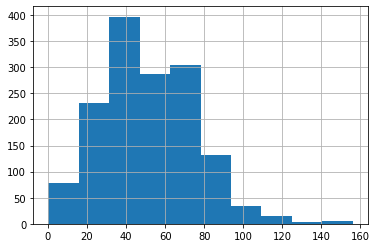

In [673]:
(fr.filter(regex='QC').std(axis=1)/fr.filter(regex='QC').mean(axis=1)*100).hist()

In [9]:
(fr.filter(regex='QC2|QC3').std(axis=1)/fr.filter(regex='QC2|QC3').mean(axis=1)) < 0.5

0        True
1        True
2        True
3        True
4        True
        ...  
1482     True
1483     True
1484     True
1485     True
1486    False
Length: 1487, dtype: bool

In [10]:
fr.drop(fr[(fr.filter(regex='QC2|QC3').std(axis=1)/fr.filter(regex='QC2|QC3').mean(axis=1)) > 0.5].index)

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
0,0.536,679.05463,+,2.408421e+07,NaN,NaN,49,6939.264074,7204.617522,1.145548e+07,...,1.771940e+07,1.647246e+07,1.366983e+07,1.568381e+07,1.290439e+07,1.353820e+07,1.360893e+07,8616.499626,7755.590041,7473.385618
1,0.537,641.10870,+,5.522238e+07,NaN,NaN,36,4957.644286,5147.221739,4.677270e+07,...,3.852845e+07,4.172903e+07,6.220326e+06,4.279894e+07,3.789880e+07,3.219858e+07,2.889174e+07,5992.201567,5261.096948,5307.954232
2,0.541,951.15973,-,3.238113e+07,NaN,NaN,10,31210.491250,6708.897037,1.625939e+07,...,1.569916e+07,1.912593e+07,1.216820e+07,2.036861e+07,1.952822e+07,1.953922e+07,1.543462e+07,9861.409380,94752.403070,72744.082630
3,0.542,329.03067,-,2.882770e+08,NaN,NaN,55,35414.640900,7612.606206,1.290199e+08,...,2.882770e+08,1.142664e+08,1.452781e+08,1.763549e+08,2.236196e+08,1.790767e+08,1.651242e+08,235854.330500,107515.844600,82542.935410
4,0.544,969.13147,-,1.697296e+07,NaN,NaN,14,36157.660320,7772.323038,1.089197e+07,...,6.578465e+06,8.023917e+06,4.351532e+06,1.132409e+07,1.040661e+07,8.373267e+06,9.059848e+06,240802.689200,109771.588600,84274.733400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,20.163,974.91180,+,4.515337e+06,NaN,NaN,4,17222.650420,18967.803010,6.585959e+05,...,3.896841e+05,3.842817e+05,5.605229e+05,3.046913e+05,1.110650e+06,5.464527e+05,7.021282e+05,22267.160020,29833.815490,19494.374600
1482,20.175,593.58716,+,3.296976e+06,NaN,NaN,19,13463.679470,14827.939600,1.801313e+06,...,2.390561e+05,1.291650e+06,2.886770e+05,8.545798e+05,6.331233e+05,1.647502e+06,2.088592e+05,15946.120300,15354.653040,15239.583030
1483,20.196,871.80945,+,2.595829e+06,NaN,NaN,6,11170.753640,11883.403090,1.053780e+06,...,7.948007e+04,8.523295e+05,8.869149e+04,4.884374e+05,1.233201e+05,1.052764e+06,4.261791e+04,12779.535150,11523.481420,11266.124030
1484,20.435,1003.93829,+,3.203813e+06,NaN,NaN,4,12695.823470,13819.097200,5.844701e+05,...,3.421911e+05,3.890957e+05,7.912981e+05,1.910285e+05,1.147269e+06,4.434897e+05,5.509051e+05,23229.657890,14761.180040,17844.172830


### Basic feature engineering:

1. Remove blank and water samples (5 total)

2. Separate into control vs test groups

3. Create 2nd pandas table of metadata compiled from Huishi's metadata info spreadsheet:
    1. "20210421_FBGRBGOGTT_Huishi sample sheet.xlsx"
    2. Include timepoints in pd.datetime format
    3. Include each rat's phenotypes (glucose level, insulin, weight, age, etc.) 
    
4. Explanation of sample metadata:
    1. Rat names: "T1060M", "T1061M", ... "T1102M" (not all number
        1. Not all numbers between 1060 and 1102 are included.
        2. NB: Not all rats had samples submitted for MS lipidomics
        
    2. RBG vs FBG 
        1. RBG = random blood glucose (randomly sampled blood glucose levels)
        2. FBG = fasted blood glucose (collected after fasting at pre-determined time intervals)
        
    3. Age
        1. Date of birth, between 1/23/2021 and 2/1/2021
        2. Metadata from Huishi organized based on "X weeks old" 
            1. Time points: 4, 8, 9, 10, 11, 12 weeks old 
            
     4. Weight
         1. Weights given as around 100, I assume this is grams
         2. Also gives "Weight gain %" or "Weight loss %"
         3. Also includes "Weight (pre-fasting)"
         3. Also includes "4 to 8 weeks" "Weight gain %"
         5. One of the weights has a note "euthanized due to tail injury" and blanks for that rat thereafter
            
     5. Date and time
         1. Given in "When" column
         2. Formats given as "3/26 6pm" or "4/10 10:30am" or "03/29 10:30am" 
      
    10. Other metadata:
        1. Note at top of metadata spreadsheet: "Fasting from 6:30pm to 10:30am; Light cycle 10am to 10pm"
            1. Referring to fasting periods for nile rats, and when the lights were on/off in the room
        2. "Collected hypothalamus, interscapular white fat, interscapular brown fat, inguinal white fat, mesenteric visceral white rat, pancreas, duodenum, jejunum, ileum, liver,"
        3. "Isoflurane 3% with 2L/min oxygen (~2min to go under)"
        4. Under the post-mortem phenotypes: "Used pre-fasting weight to calculate amount of dextrose"


In [671]:
## For easier grouping of files based on RBG vs FBG, analytical order, pairing of samples, and rat label,
## create a dataframe file_grouping that contains all labels and groups per analysis file.
## Columns = rawfile name; lipidex final results filename; order; RBG vs FBG; rat number labels

file_grouping = pd.read_csv(r'..\data\metadata\20210729_AJ_Toh_RatPlasma_Sequence_Exported.csv', skiprows=1)
file_grouping['analytical_run_order'] = range(1, 68)
file_grouping = file_grouping[['File Name', 'analytical_run_order']]

rawfile_cols = fr.filter(regex='.raw').columns

# Dictionary of rawfile names to Lipidex final results file names (which includes (F1), (F2), etc. in column name)
sample_name_to_file_name_map = {}

for file in rawfile_cols.to_list():
    for sfile in file_grouping['File Name'].to_list():
        if sfile in file:
            sample_name_to_file_name_map[sfile] = file

# correlates rawfile name to lipidex final results filename
file_grouping['fr_name'] = file_grouping['File Name'].apply(lambda name: sample_name_to_file_name_map[name] )
    
# Extract the rat label from filename using this horrible chain of str.split() methods 
file_grouping['rat_label'] = file_grouping[file_grouping['File Name'].str.contains('Glucose_T')]['File Name'] \
                                           .str.split('Glucose_T').str[1] \
                                           .str.split('M_2021').str[0] \
                                           .astype('float')

def parse_bg_type(filename):
    if 'RBG' in filename:
        return 'RBG'
    if 'FBG' in filename:
        return 'FBG'

file_grouping['bg_type'] = file_grouping[file_grouping['File Name'].str.contains('RBG|FBG')]['File Name'] \
                                         .apply(parse_bg_type)

# if a file has quant_file == True, then it's one of the 60 runs we will use for data analysis
file_grouping['quant_file'] = ~file_grouping['analytical_run_order'].isin([1,2,3,4,5,6,67])

# extract the week label from filename using chain of str.split()
file_grouping['week'] = file_grouping[file_grouping['File Name'].str.contains('Glucose_T')]['File Name'] \
                                           .str.split('_').str[6] \
                                           .str.split('wk').str[0].astype('float').astype('Int64')

# Extract the lipidex file number from lipidex fr_name 
file_grouping['lipidex_file_number'] = file_grouping['fr_name'].str.extract(r'\(F(.*?)\)').astype('int')

file_grouping['date'] = pd.to_datetime(file_grouping[file_grouping['quant_file'] == True]['File Name'].str.split('_').str[5])

def gluc_tol(rat_label):
    # Original email was wrong, 1091 and 1093 are normal, NOT 1092 and 1093. 
    if rat_label in [1091, 1093]:
        return 'normal'
    elif rat_label in [1076, 1082, 1101]:
        return 'diabetic'
    elif rat_label in [1092, 1060, 1102, 1062, 1074]:
        return 'impaired'
    else:
        return None

file_grouping['glucose_tolerance'] = file_grouping['rat_label'].apply(gluc_tol)


file_grouping.to_csv(r'..\data\metadata\file_groupings.csv')

file_grouping.head(10)

,File Name,analytical_run_order,fr_name,rat_label,bg_type,quant_file,week,lipidex_file_number,date,glucose_tolerance
0,20210729_AJ_Toh_RatBloodGlucose_Water_R1,1,20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),NaN,NaN,False,<NA>,65,NaT,None
1,20210729_AJ_Toh_RatBloodGlucose_Water_R2,2,20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),NaN,NaN,False,<NA>,66,NaT,None
2,20210729_AJ_Toh_RatBloodGlucose_Water_R3,3,20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67),NaN,NaN,False,<NA>,67,NaT,None
3,20210729_AJ_Toh_RatBloodGlucose_SolventBlank,4,20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),NaN,NaN,False,<NA>,2,NaT,None
4,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank,5,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),NaN,NaN,False,<NA>,1,NaT,None
5,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1,6,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11),1062.0,FBG,False,9,11,NaT,impaired
6,20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG,7,20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27),1076.0,FBG,True,10,27,2021-04-05,diabetic
7,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG,8,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9),1062.0,FBG,True,8,9,2021-03-22,impaired
8,20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG,9,20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49),1093.0,FBG,True,9,49,2021-04-02,normal
9,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG,10,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),1060.0,RBG,True,8,4,2021-03-25,impaired


In [ ]:
## Correlate the file_groupings df to the phenotype data in obs
# To do that, use the 'rat_label' and 'date' columns in file_groupings 
# to correlate to 'animal' and ['datetime'].dt.date in obs 

file_grouping = pd.read_csv(r'..\data\metadata\file_groupings.csv')

testrow = file_grouping.iloc[35]

obs[(obs['animal'] == testrow['rat_label']) & (obs['datetime'].dt.date == testrow['date'])]

In [14]:
## T1062M_20210329_9wk_FBG Is sampled 3 times, each with a QC label.
## The 1st QC has low quants and we could ignore.
## The 2nd and 3rd QC appear OK, so use the QC2 as the one to include in all samples
## There is no non-QC file for T1062M_20210329_9wk_FBG

qc1qc3 = fr.filter(regex='QC1|QC3')

blanks = fr.filter(regex='Blank|Water')

fbg = fr.filter(regex='FBG')
fbg.columns  ## Beware that QCs are still in this

rbg = fr.filter(regex='RBG')

In [15]:
## Which animals were used in the experiment? 
## Because not all animals in the metadata had samples submitted for plasma lipidomics

cols = fr.columns

animal_numbers = []

for col in cols:
#     print(col)
    search = re.search(r"(?<=ose\_T)(.*)(?=M_)", str(col))
    if search:
#         print(search.groups()[0])
        animal_numbers.append(int(search.groups()[0]))
    
animals_used = list(set(animal_numbers))
print(animals_used)  # [1091, 1060, 1092, 1062, 1093, 1101, 1102, 1074, 1076, 1082]

[1091, 1060, 1092, 1062, 1093, 1101, 1102, 1074, 1076, 1082]
